# Data Preparation

My initial task is to prepare and get myself familiar with the dataset [Suomi24-toxicity-annotated](https://huggingface.co/datasets/TurkuNLP/Suomi24-toxicity-annotated).

In [1]:
! pip install -q git+https://github.com/huggingface/transformers seaborn umap-learn[plot]

In [2]:
from datasets import load_dataset

dataset = load_dataset(
    "TurkuNLP/Suomi24-toxicity-annotated",
    split="test",
)

dataset.shuffle()

Using custom data configuration default


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset suomi24-toxicity-annotated downloaded and prepared to /root/.cache/huggingface/datasets/TurkuNLP___suomi24-toxicity-annotated/default/1.1.0/dedc184b7b2b91f4ea037e38b1d7bac8f62e7291e8c8c79ef04c5f33fae90434. Subsequent calls will reuse this data.


Dataset({
    features: ['text', 'label'],
    num_rows: 2260
})

Now that dataset is downloaded, it's a good idea to do some EDA and e.g. see in what proportion data is labeled.

<AxesSubplot: xlabel='count'>

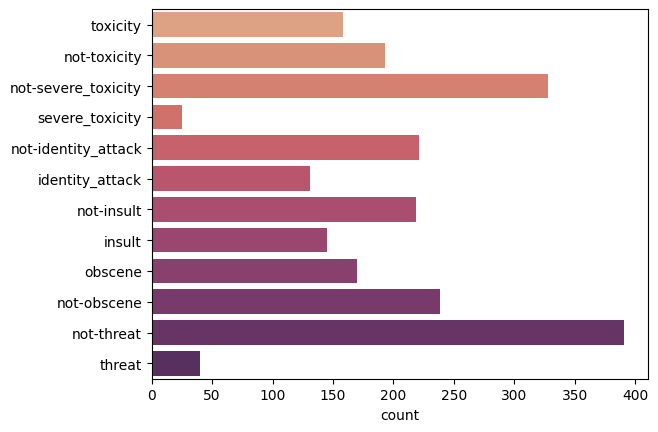

In [3]:
import seaborn as sns

sns.countplot(y=dataset["label"], palette="flare")

In [4]:
from transformers import pipeline

checkpoint = "TurkuNLP/bert-large-finnish-cased-toxicity"
feature_extractor = pipeline("feature-extraction",framework="pt",model=checkpoint, device="cuda")

In [5]:
labels, texts = dataset['label'], dataset['text']

In [6]:
from tqdm import tqdm

wordVecs = []

for text in tqdm(texts):
    e = feature_extractor(texts[0], return_tensors="pt")[0].numpy().mean(axis=0)

    wordVecs.append(e)

  0%|          | 0/2260 [00:00<?, ?it/s]

  0%|          | 9/2260 [00:00<02:25, 15.47it/s]/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2260/2260 [01:12<00:00, 31.20it/s]


In [7]:
colors = list(set(labels))

color_labels = [colors.index(l) for l in labels]

In [8]:
colors

['severe_toxicity',
 'not-severe_toxicity',
 'not-insult',
 'insult',
 'not-toxicity',
 'not-identity_attack',
 'toxicity',
 'obscene',
 'identity_attack',
 'not-obscene',
 'not-threat',
 'threat']

One thing to take account is that the embedding vectors have quite large dimensionality and projecting them onto two dimensions might be unpractical.


In [9]:
import umap

mapped_embedding = umap.UMAP(random_state=42).fit_transform(wordVecs)

/usr/local/lib/python3.9/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


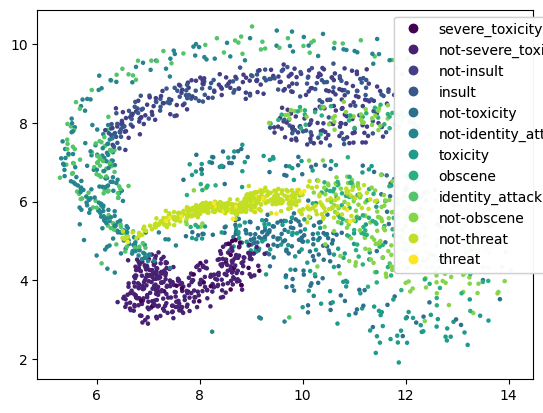

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

scatter = ax.scatter(
    mapped_embedding[:,0], 
    mapped_embedding[:,1], 
    c=color_labels, 
    s=5
)

legend_elements = (scatter.legend_elements()[0], colors)

legend = ax.legend(*legend_elements, loc="upper right", bbox_to_anchor=(1.1, 1))
ax.add_artist(legend)

plt.show()

Suprisingly e.g. `severe_toxicity`, `insult` and `identity_attack` create a cluster on top of the graph if I'm reading it right. For some reason `threat` and `not-threat` seem to mix up in the center. It's almost like you could draw a line through the middle to separate the toxic content from non-toxic?